In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
import math

In [3]:
import platform, matplotlib
from matplotlib import rc

# '-' 기호 제대로 보이기
matplotlib.rcParams['axes.unicode_minus'] = False

# 윈도우
if platform.system() == 'Windows':
    rc('font', family="Malgun Gothic")
# 맥
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
# 리눅스
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')

In [4]:
import joblib
from sklearn.model_selection import train_test_split

# Data load

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# train = pd.read_csv('train.csv', parse_dates=['date'])
# test = pd.read_csv('test.csv', parse_dates=['date'])

## 불필요 columns 제거

In [6]:
train.drop('id', axis=1, inplace=True)

In [7]:
test.drop('id', axis=1, inplace=True)

# Column 설정

In [8]:
target = 'target'

In [9]:
columns_cat = joblib.load('columns_cat.pkl')
columns_binary_num = joblib.load('columns_binary_num.pkl')
columns_binary_cat = joblib.load('columns_binary_cat.pkl')
columns_dt = joblib.load('columns_dt.pkl')

In [10]:
columns_num = []

for column in train.columns :
    
    if column not in columns_cat :
        columns_num.append(column)

In [11]:
for column in columns_dt :
    columns_num.remove(column)

In [12]:
columns_cat

['bin_3',
 'bin_4',
 'nom_0',
 'nom_1',
 'nom_2',
 'nom_3',
 'nom_4',
 'nom_5',
 'nom_6',
 'nom_7',
 'nom_8',
 'nom_9',
 'ord_1',
 'ord_2',
 'ord_3',
 'ord_4',
 'ord_5',
 'bin_0',
 'bin_1',
 'bin_2',
 'ord_0',
 'day',
 'month']

In [13]:
columns_num

['target']

In [14]:
columns_dt

[]

In [15]:
joblib.dump(columns_num, 'columns_num.pkl')

['columns_num.pkl']

## datetime 설정

# Train & test set 분리

In [16]:
# train, test = train_test_split(data, random_state=30)
# train, test = train_test_split(data, stratify=target, random_state=30)   # 계층적 sampling

# EDA
- EDA는 train set으로만 진행
- Train set가 너무 크면, 탐색을 위한 별도의 sampling 진행

In [17]:
# train_sp = train.sample(frac=0.1, random_state=30)

## 수치형 data

In [18]:
# sns.pairplot(train[columns_num], hue=target, corner=True, height=10)   # pairplot은 height로 size 조정

In [19]:
corr_matrix = train.corr()
corr_matrix[target].sort_values(ascending=False)

target    1.000000
month     0.090629
ord_0     0.090208
bin_2     0.011947
bin_0     0.002186
day      -0.015867
bin_1    -0.088899
Name: target, dtype: float64

<AxesSubplot:>

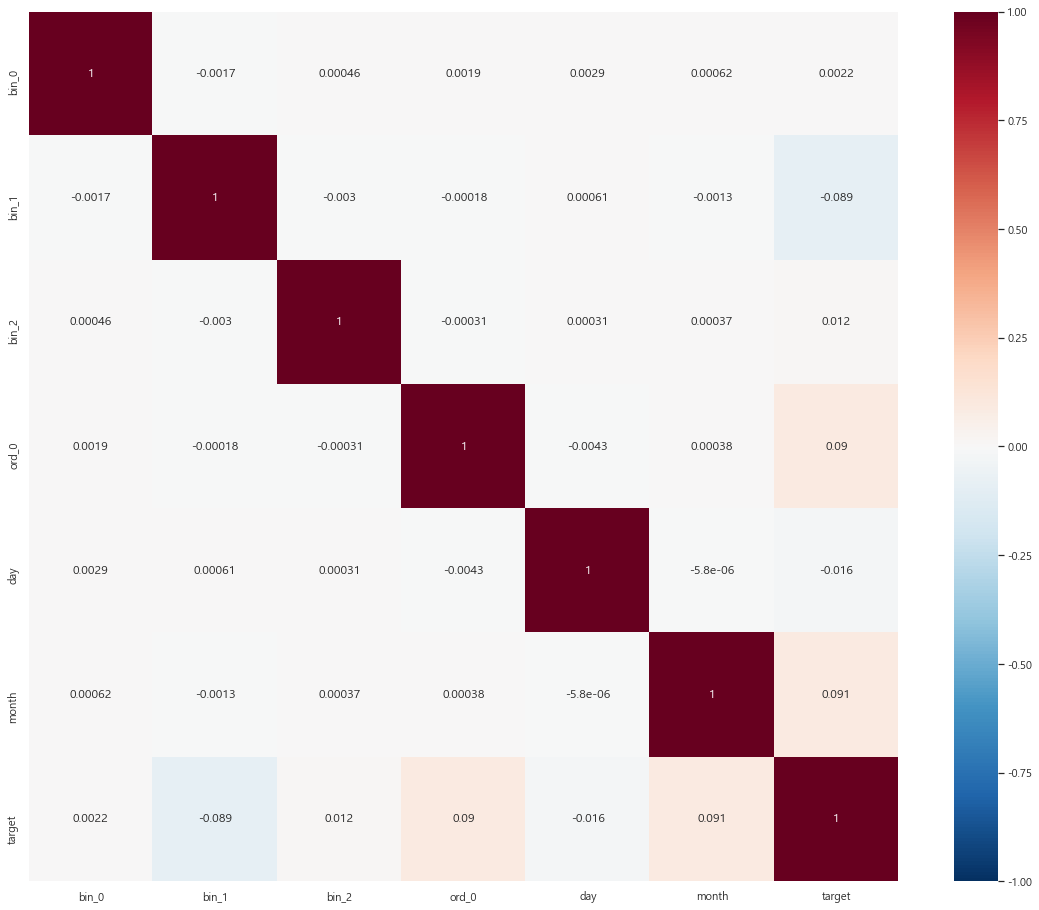

In [20]:
fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', vmin=-1, vmax=1, square=True, cbar=True, ax=ax)

## 범주형 data

In [21]:
def get_crosstab(data, column, target) :
    crosstab = pd.crosstab(data[column], data[target], normalize='index') * 100
    
    return crosstab

In [22]:
# 도형 객체를 순회하며 막대 그래프 상단에 비율 표시
def write_percent_by_target(ax, data, crosstab) :
    
    for i, patch in enumerate(ax.patches) :   # Rectangle 객체
        height = patch.get_height()   # 도형 높이(데이터 개수)
        width = patch.get_width()   # 도형 너비
        left_coord = patch.get_x()   # 도형 왼쪽 테두리의 x축 위치
        percent = crosstab.T.values.reshape(-1, 1)[i][0]   # 타깃 값 비율, array의 값을 가져오기 위해 마지막에 [0]을 사용
        
        # (x, y) 좌표에 텍스트 입력
        ax.text(x = left_coord + width / 2,   # x축 위치
                y = height + len(data) * 0.001,   # y축 위치
                s = f'{percent:1.1f}%',   # 입력 텍스트
                ha = 'center')   # 가운데 정렬

In [23]:
columns_cat_count = []

for column in columns_cat :
    
    if len(train[column].value_counts()) <= 4 :
        columns_cat_count.append(column)

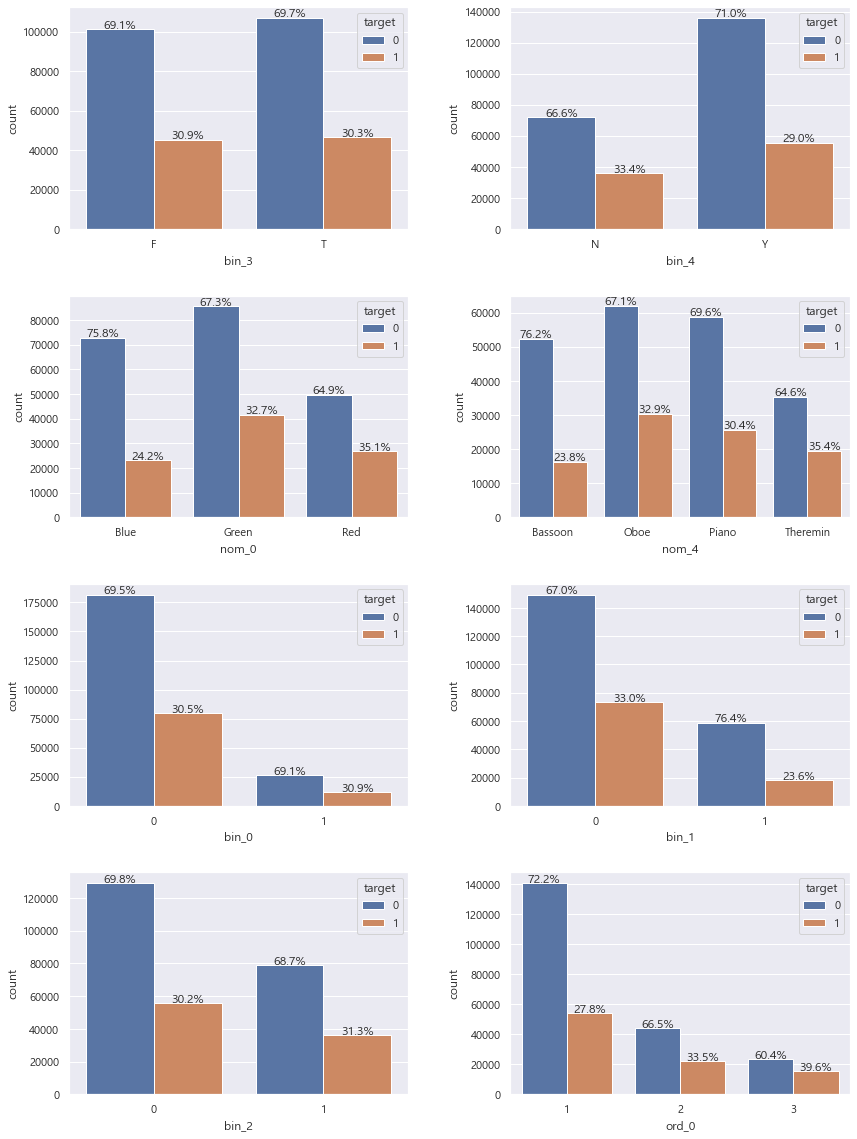

In [24]:
k = len(columns_cat_count)
m = math.ceil(k / 2)

plt.figure(figsize=(14, 5 * m))
grid = plt.GridSpec(m, 2, wspace=0.3, hspace=0.3)

for i in range(k) :
    crosstab = get_crosstab(train, columns_cat_count[i], target)
    
    ax = plt.subplot(grid[i])
    sns.countplot(data=train, x=columns_cat_count[i], hue=target, order=crosstab.index, ax=ax)
    write_percent_by_target(ax, train, crosstab)

In [25]:
# 도형 객체를 순회하며 막대 그래프 상단에 비율 표시
def write_percent(ax, data) :
    
    for i, patch in enumerate(ax.patches) :   # Rectangle 객체
        height = patch.get_height()   # 도형 높이(데이터 개수)
        width = patch.get_width()   # 도형 너비
        left_coord = patch.get_x()   # 도형 왼쪽 테두리의 x축 위치
        percent = height / len(data) * 100 # 타깃 값 비율
        
        # (x, y) 좌표에 텍스트 입력
        ax.text(x = left_coord + width / 2,   # x축 위치
                y = height + len(data) * 0.001,   # y축 위치
                s = f'{percent:1.1f}%',   # 입력 텍스트
                ha = 'center')   # 가운데 정렬

In [26]:
def plot_pointplot(ax, column, crosstab) :
    crosstab = crosstab.reset_index()
    
    ax2 = ax.twinx() # x축은 공유하고 y축은 공유하지 않는 새로운 축 생성
    ax2 = sns.pointplot(data=crosstab, x=column, y=1, order=crosstab[column].values, color='k', legend=False)
    ax2.set_ylim(crosstab[1].min() * 0.9, crosstab[1].max() * 1.1)
    ax2.set_ylabel('Target 1 ratio(%)')

In [27]:
from pandas.api.types import CategoricalDtype 

ord_1_value = ['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster']
ord_2_value = ['Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']

# 순서를 지정한 범주형 데이터 타입
ord_1_dtype = CategoricalDtype(categories=ord_1_value, ordered=True)
ord_2_dtype = CategoricalDtype(categories=ord_2_value, ordered=True)

# 데이터 타입 변경
train['ord_1'] = train['ord_1'].astype(ord_1_dtype)
train['ord_2'] = train['ord_2'].astype(ord_2_dtype)

In [28]:
# value값을 20개 이하로 가지는 column을 선택
# value값이 너무 많으면 countplot을 그리는데 시간이 너무 많이 소요됨
columns_cat_count = []

for column in columns_cat :
    
    if 4 < len(train[column].value_counts()) <= 20 :
        columns_cat_count.append(column)

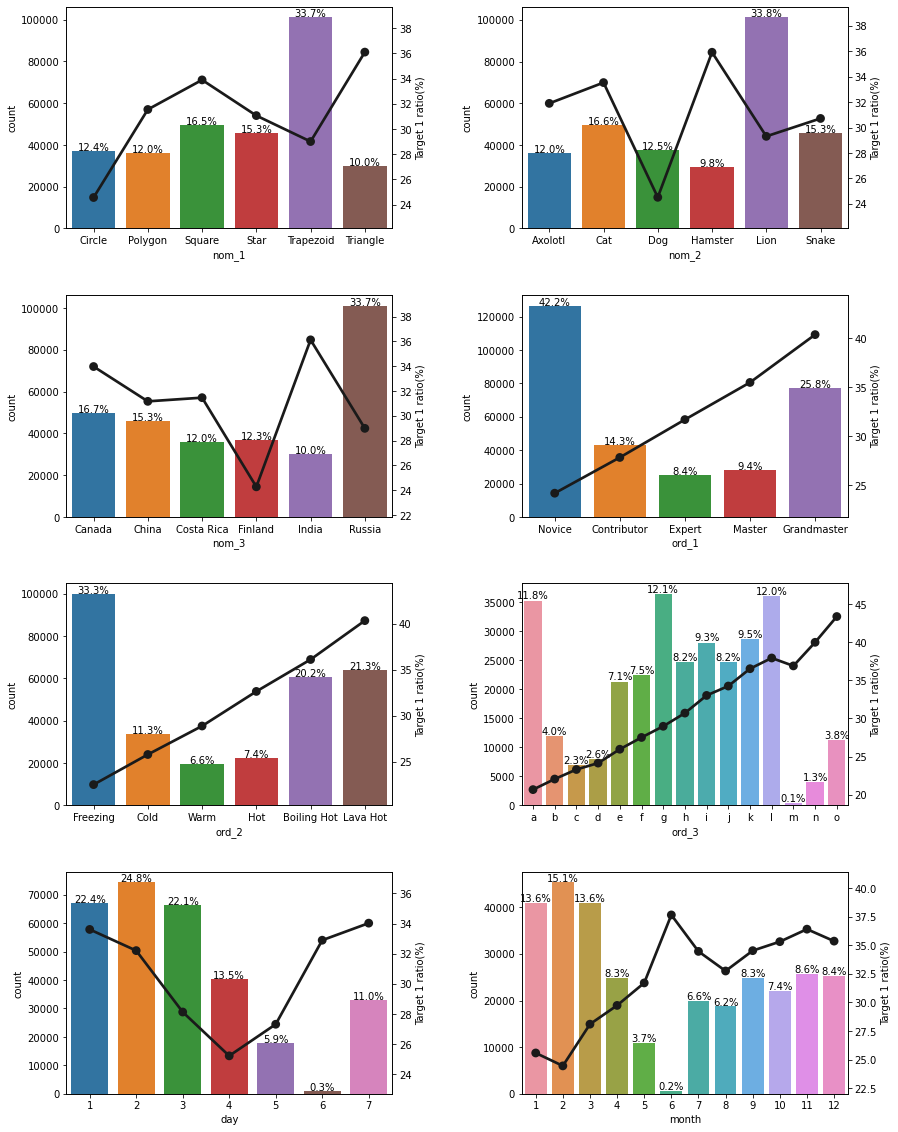

In [29]:
sns.reset_orig()

k = len(columns_cat_count)
m = math.ceil(k / 2)

plt.figure(figsize=(14, 5 * m))
grid = plt.GridSpec(m, 2, wspace=0.4, hspace=0.3)

for i in range(k) :
    crosstab = get_crosstab(train, columns_cat_count[i], target)
    
    ax = plt.subplot(grid[i])
    sns.countplot(data=train, x=columns_cat_count[i], order=crosstab.index, ax=ax)
    write_percent(ax, train)
    plot_pointplot(ax, columns_cat_count[i], crosstab)

In [30]:
columns_cat_count = []

for column in columns_cat :
    
    if 20 < len(train[column].value_counts()) <= 40 :
        columns_cat_count.append(column)

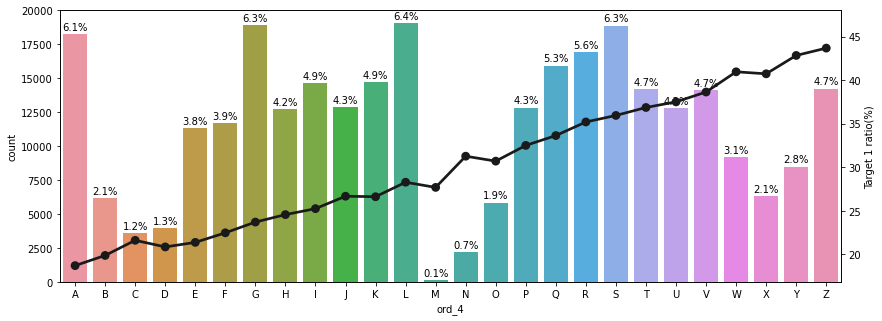

In [31]:
sns.reset_orig()

k = len(columns_cat_count)
m = math.ceil(k / 2)

plt.figure(figsize=(14, 5 * m))
grid = plt.GridSpec(m, 1, hspace=0.3)

for i in range(k) :
    crosstab = get_crosstab(train, columns_cat_count[i], target)
    
    ax = plt.subplot(grid[i])
    sns.countplot(data=train, x=columns_cat_count[i], order=crosstab.index, ax=ax)
    write_percent(ax, train)
    plot_pointplot(ax, columns_cat_count[i], crosstab)

<AxesSubplot:xlabel='month', ylabel='count'>

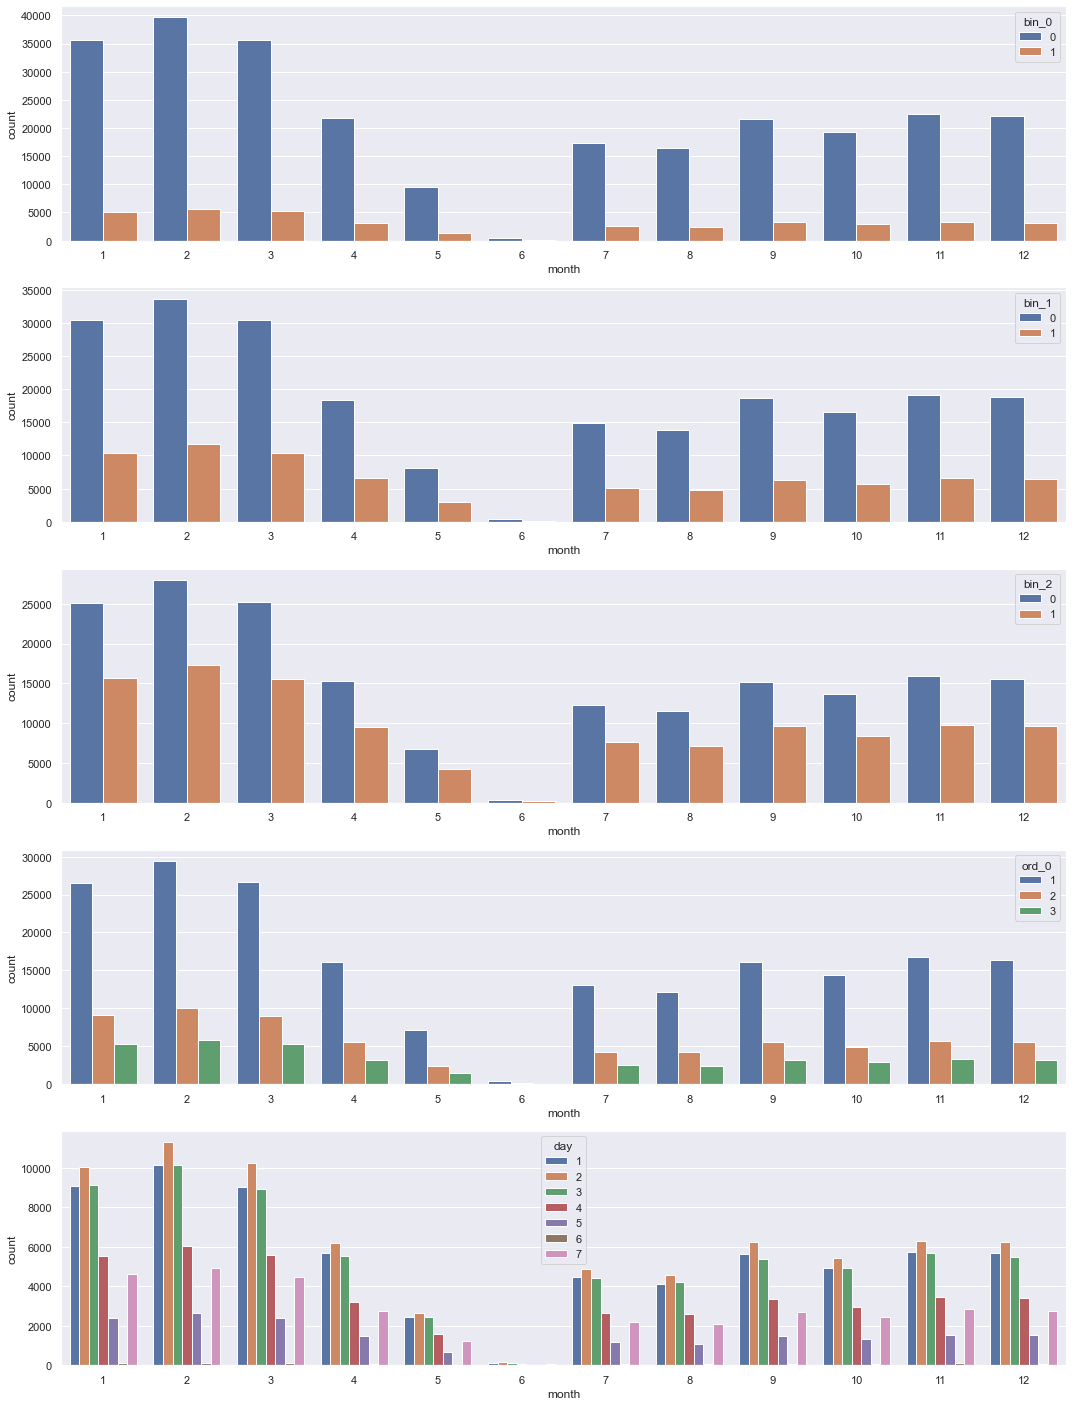

In [32]:
sns.set()

fig, (ax1, ax2, ax3, ax4, ax5)= plt.subplots(nrows=5, figsize=(18, 5*5))
sns.countplot(data=train, x='month', hue='bin_0', ax=ax1)
sns.countplot(data=train, x='month', hue='bin_1', ax=ax2)
sns.countplot(data=train, x='month', hue='bin_2', ax=ax3)
sns.countplot(data=train, x='month', hue='ord_0', ax=ax4)
sns.countplot(data=train, x='month', hue='day', ax=ax5)

## target 확인

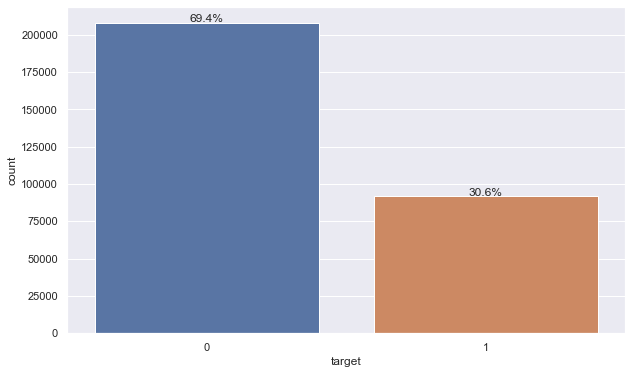

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.countplot(data=train, x=target)
write_percent(ax, train)

In [34]:
# fig, ax = plt.subplots(figsize=(10, 6))
# sns.distplot(train[target], ax=ax)

In [35]:
# target 분포를 log scale로 확인
# 조금 더 정규 분포에 가까운 분포를 띄는지 확인하기 위함
# fig, ax = plt.subplots(figsize=(10, 6))
# sns.distplot(np.log1p(train[target]), ax=ax)

# (추가) target scale 변경

In [36]:
# train_og = train.copy()

In [37]:
# train[target] = np.log1p(train[target])

## 수치형 data